In [45]:
%cd "~/projects/spartDM/"

import os
print(f"current pwd: {os.getcwd()}")

from src.monai.diffae_resnet18 import DiffAEResNet18
from src.monai.anomaly_map import AnomalyMap

import torch
import numpy as np


/home/kdang/projects/spartDM
current pwd: /home/kdang/projects/spartDM


/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [on]
Loading model from: /home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/lpips/weights/v0.1/squeeze.pth
(1, 1, 64, 64)


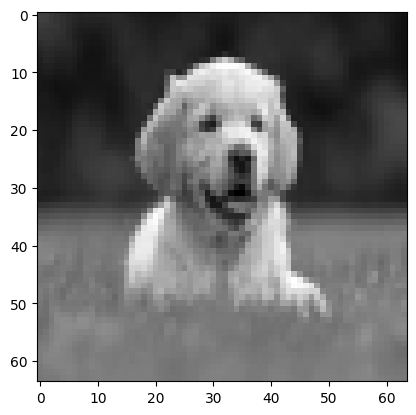

In [161]:
model = DiffAEResNet18(emb_dim=512)
# ano_map = AnomalyMap()

# inputs = torch.randn(10, 1, 64, 64)
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange


test_img_path = "/home/kdang/Downloads/dog.jpg"
# Load image
img = Image.open(test_img_path)
img = img.convert(mode="L")
img = img.resize((64, 64))
# Convert to NumPy array
inputs = np.array(img) / 255.0

# increase batch channel

inputs = rearrange(inputs, "h w -> 1 1 h w")
print(inputs.shape)

plt.imshow(inputs.squeeze(), cmap="gray")

inputs = torch.from_numpy(inputs)
inputs = inputs.float()

device = "cpu"
inputs = inputs.to(device)


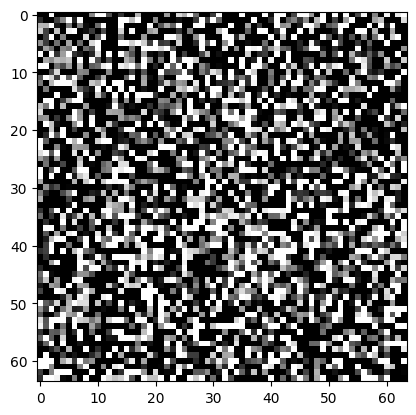

In [191]:

x_rec = model.sample_from_image(inputs, noise_level=500, num_inference_steps=1)
x_rec = torch.clamp(x_rec, 0 ,1)

# 2. Calculate initial anomlay map from pixel-wise error and LPIPS score
# e.q (9) in AutoDDPM paper https://arxiv.org/abs/2305.19643
# mask = 
        
x_res = model.ano_map.compute_residual(inputs, x_rec, hist_eq=False)
lpips_mask = model.ano_map.lpips_loss(inputs, x_rec, retPerLayer=False)
#
# anomalous: high value, healthy: low value
x_res = np.asarray(
    [(x_res[i] / np.percentile(x_res[i], 95)) for i in range(x_res.shape[0])]
).clip(0, 1)
combined_mask_np = lpips_mask * x_res
combined_mask = torch.Tensor(combined_mask_np).to(inputs.device)

plt.imshow(x_rec[0].squeeze(), cmap="gray")

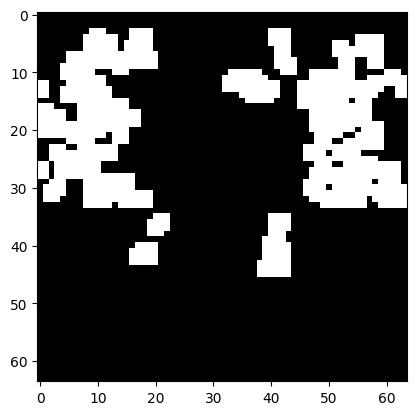

In [186]:
mask_threshold = torch.tensor(
                np.asarray(
                    [
                        (np.percentile(combined_mask[i].cpu().detach().numpy(), 95))
                        for i in range(combined_mask.shape[0])
                    ]
                ).clip(0, 1)
            )

combined_mask_binary = torch.cat(
    [
        torch.where(
            combined_mask[i] > mask_threshold[i],
            torch.ones_like(torch.unsqueeze(combined_mask[i], 0)),
            torch.zeros_like(combined_mask[i]),
        )
        for i in range(combined_mask.shape[0])
    ],
    dim=0,
)

combined_mask_binary_dilated = model.ano_map.dilate_masks(combined_mask_binary)
mask_in_use = combined_mask_binary_dilated

plt.imshow(mask_in_use[0].squeeze(), cmap="gray")

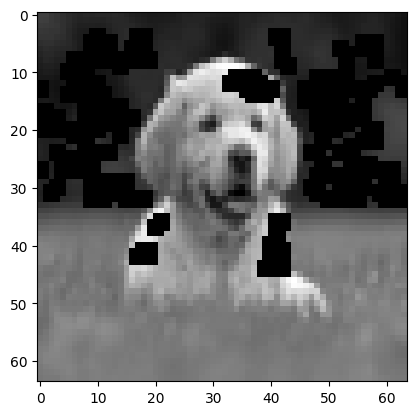

In [189]:
# In-painting setup
# 1. Mask the original image (get rid of anomalies) and the reconstructed image (keep pseudo-healthy
# counterparts)
x_masked = (1 - mask_in_use) * inputs
x_rec_masked = mask_in_use * x_rec



# plt.imshow(x_masked[0].squeeze(), cmap="gray")
plt.imshow(x_masked[0].squeeze(), cmap="gray")

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

kl_loss = nn.KLDivLoss(reduction="batchmean")
# input should be a distribution in the log space
input = F.log_softmax(torch.randn(3, 5, requires_grad=True), dim=1)
# Sample a batch of distributions. Usually this would come from the dataset
target = F.softmax(torch.rand(3, 5), dim=1)
output = kl_loss(input, target)

kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
log_target = F.log_softmax(torch.rand(3, 5), dim=1)
output = kl_loss(input, log_target)
output

tensor(0.5011, grad_fn=<DivBackward0>)